## Experiments in *Private Summation in the Multi-Message Shuffle Model* (CCS 2020).
**Borja Balle, James Bell, Adrià Gascón, and Kobbi Nissim**

### Synthetic Experiments

We considered both a dataset of uniformly random samples from $[0,1]$ (which we denote "ur") and a sample from a normal distribution with mean $0.573$
and standard deviation $.1$, which we refer to as "normal". 
A set of plots provides a comparison between the different protocols in the shuffle model, while the other set of plots compares the best protocol in the shuffle model with standard protocols in the central and local model.
The same trends are observed for both types of synthetic data.
As expected, the obtained accuracies are clustered according to their analytical errors,
which in turn correspond to the model they operate in. It is worth mentioning that IKOS
gives better error than CentralLaplace in these datasets. We speculate that this is due to the fact that the Geometric mechanism
works well with counts, as it is discrete.

### Real-world data Experiments

As a real-word dataset we used the Adult dataset. This dataset contains $n = 32561$ curated records from the 1994 US Census database.
This is a dataset commonly used evaluate classification algorithms. We focused on the task of differentially private
estimation the mean of the "age" attribute normalized by the maximum age (with parameters $\epsilon = 1, \delta = 1/n^2$). The generated table shows the mean and standard deviation of the error obtained by each algorithm over $20$ executions.
As expected, IKOS incurs error close to the one of CentralLaplace, and LocalLaplace has significantly worse error than the rest.
Our recursive protocols outperform the single-message protocol from~\cite{DBLP:conf/crypto/BalleBGN19} in this task, and
numerically optimized variants outperform their analytical counterparts.


In [1]:
import collections
import numpy as np
from real_sum_estimator import (NonPrivateRealSum, CentralLaplaceRealSum, LocalLaplaceRealSum,
                                CentralGeomRealSum, SingleMessageRealSum, TwoMessageRealSum,
                                TwoMessageRealSumOptimized, ThreeMessageRealSum, ThreeMessageRealSumOptimized)
estimators = [#NonPrivateRealSum,
              CentralLaplaceRealSum,
              LocalLaplaceRealSum,
              CentralGeomRealSum,
              SingleMessageRealSum,
              TwoMessageRealSum,
              TwoMessageRealSumOptimized,
              ThreeMessageRealSum,
              ThreeMessageRealSumOptimized,
              ]
estimator2str = {NonPrivateRealSum : 'NonPrivateRealSum',
                 CentralLaplaceRealSum : 'CentralLaplace',
                 LocalLaplaceRealSum : 'LocalLaplace',
                 CentralGeomRealSum : 'IKOS',
                 SingleMessageRealSum: 'SingleMessage',
                 TwoMessageRealSum : 'Recursive, 2 msg.',
                 ThreeMessageRealSum : 'Recursive, 3 msg.',
                 TwoMessageRealSumOptimized : 'Recursive, 2 msg., opt.',
                 ThreeMessageRealSumOptimized : 'Recursive, 3 msg., opt.'}

ExperimentSetting = collections.namedtuple('ExperimentSetting', ['epsilon', 'delta', 'n', 'dataset', 'data'])
num_reps = 20
epsilons = [1]
ns = [10000, 20000, 50000, 100000]
def get_delta(eps, n):
    return 1./n**2

experiment_settings = []
for eps in epsilons:
    for n in ns:
        for dataset in ['ur', 'normal']:
            experiment_settings.append(ExperimentSetting(eps, get_delta(eps, n), n, dataset, None))

def get_data(setting):
    if setting.dataset == 'half':
        data = np.array([.5 for _ in range(setting.n)])
    if setting.dataset == 'one':
        data = np.array([1. for _ in range(setting.n)])
    if setting.dataset == 'ur':
        data = np.random.uniform(0, 1, setting.n)
    if setting.dataset == 'normal':
        def clip(x):
            if x < 0:
                return 0.
            if x > 1:
                return 1.
            return x
        data = np.random.normal(.57, .1, setting.n)
    return data
        
def run_experiment(setting, estimator_cls, data):
    est = estimator_cls(setting.epsilon, setting.delta, setting.n)
    return abs(sum(data)/setting.n - est.estimate(data)/setting.n)

results = {}
show_debug_prints = False  # Set to true to see progress
for es in experiment_settings:
    data = get_data(es)
    for estimator_cls in estimators:
        std_errors = [run_experiment(es, estimator_cls, data) for _ in range(num_reps)]
        key = (es.epsilon, es.delta, es.n, es.dataset, estimator2str[estimator_cls])
        value = (np.mean(std_errors), np.std(std_errors))
        results[key] = value
        if show_debug_prints:
            print('{} ->\n\t{}'.format(key, value))

for k, v in results.items():
    if show_debug_prints:
        print('{} ->\n\t{}'.format(k, v))

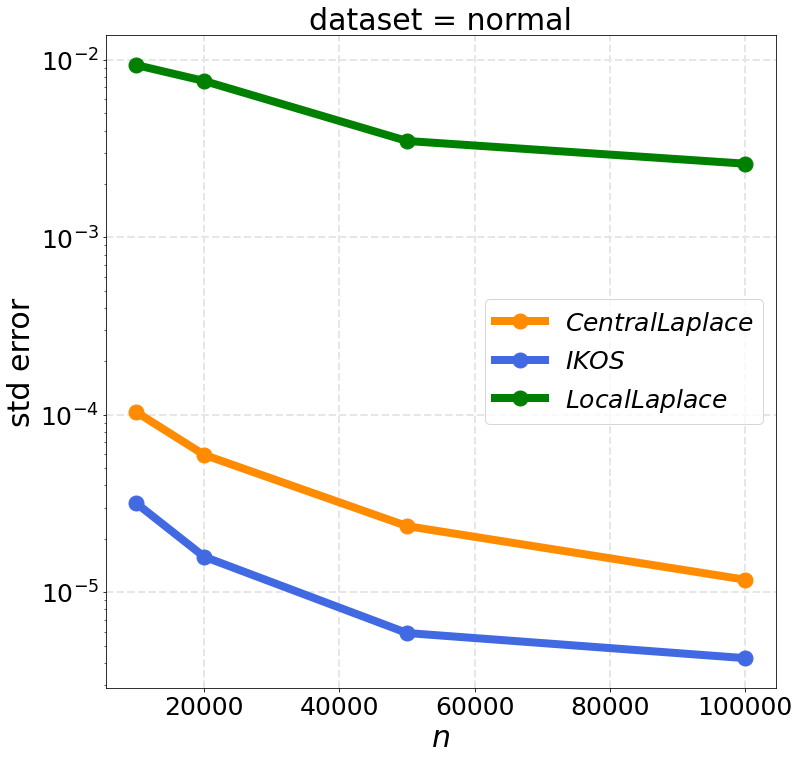

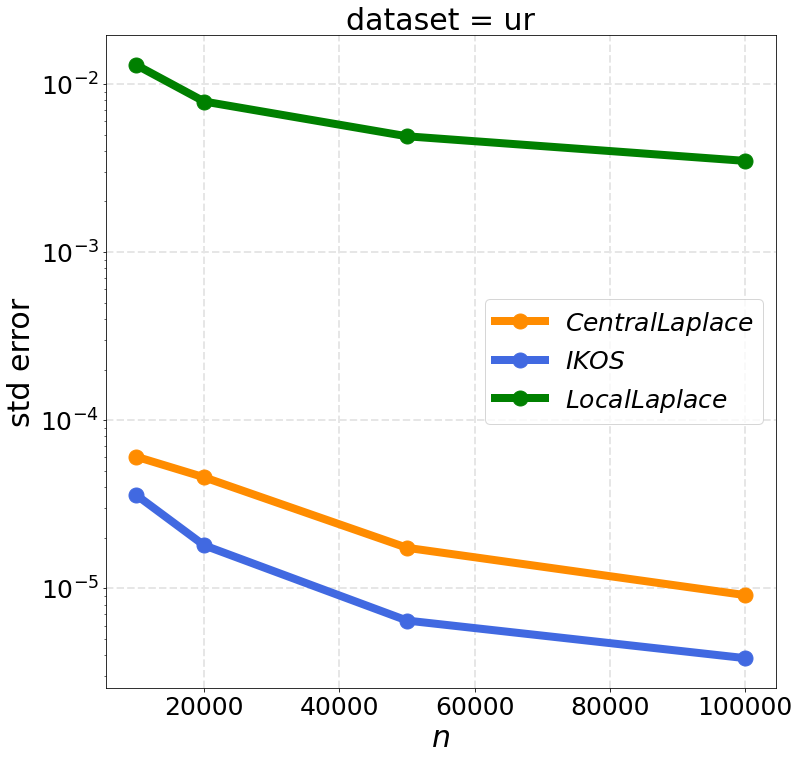

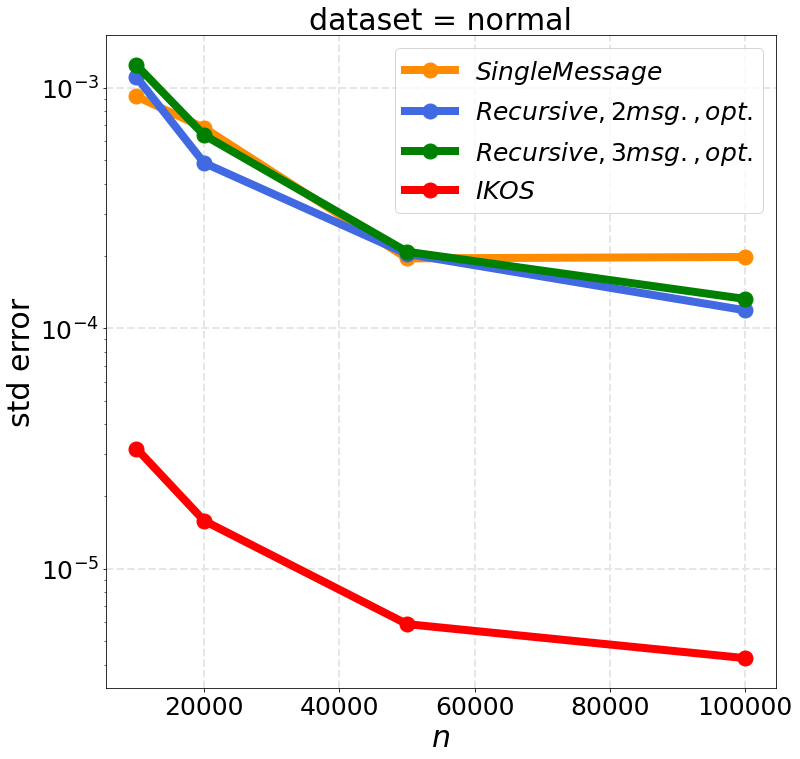

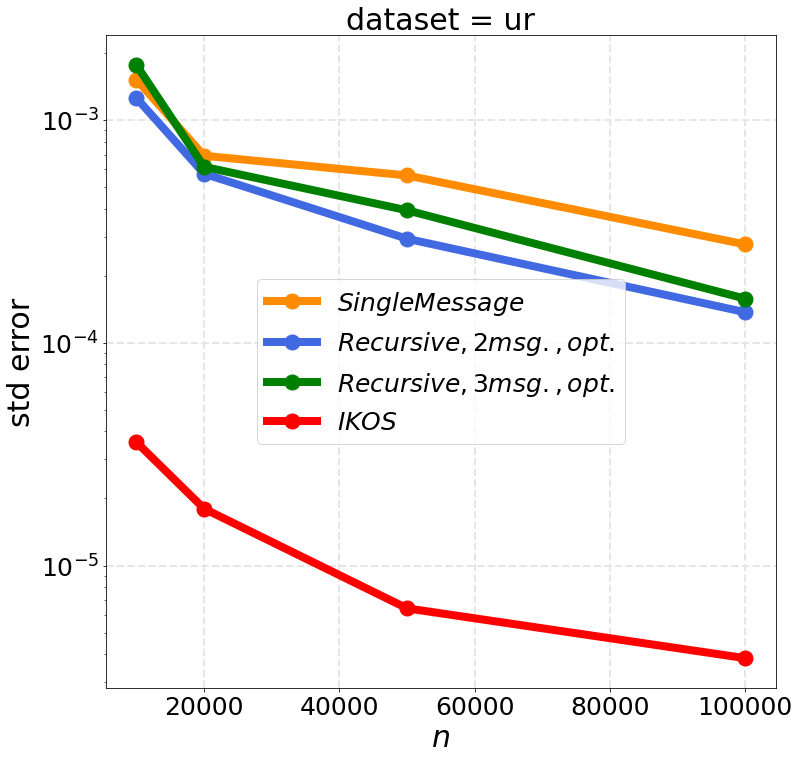

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
from matplotlib import rc
import numpy as np

matplotlib.rcParams['figure.figsize'] = (12.0, 12.0)
matplotlib.rcParams['figure.titlesize'] = 25
matplotlib.rcParams['axes.titlesize'] = 30
matplotlib.rcParams['axes.labelsize'] = 30
matplotlib.rcParams['xtick.labelsize'] = 25
matplotlib.rcParams['ytick.labelsize'] = 25
matplotlib.rcParams['legend.fontsize'] = 25
matplotlib.rcParams['lines.markersize'] = 15
matplotlib.rcParams['lines.linewidth'] = 8
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['legend.facecolor'] = 'white'
matplotlib.rcParams['legend.framealpha'] = 0.8

import collections
PlotLine = collections.namedtuple('PlotLine', 'f xs label style color show_error_bars')

def plot_panel(plotlines, xlabel_str='', ylabel_str='', title_str='', save_to_file = None):
    fig = plt.figure()
    for i, pt in enumerate(plotlines):
        ys = [pt.f(x)[0] for x in pt.xs]
        stds = [pt.f(x)[1] for x in pt.xs]
        
        w = 0.00
        width = lambda p, w: 2**(np.log2(p)+w/2.)-2**(np.log2(p)-w/2.)
        #plt.bar(np.array(pt.xs) + width(pt.xs,w) * (i-3/2), ys, yerr=stds, label=pt.label,
        #            color=pt.color, width=width(pt.xs,w), edgecolor='white', log=True,ec="k", align="edge",
        #            ecolor='black')
        if pt.show_error_bars:
            plt.errorbar(pt.xs + width(pt.xs,w) * 3*(i-1)/2, ys,
                         yerr=stds, label=pt.label, fmt='o',
                         linestyle=pt.style, color=pt.color)
        else:
            plt.plot(pt.xs, ys, label=pt.label,
                     linestyle=pt.style, color=pt.color, marker = 'o')
    
    plt.legend()
    plt.xlabel(xlabel_str)
    plt.ylabel(ylabel_str)
    plt.title(title_str)
    plt.grid(True, lw = 2, ls = '--', c = '.90')
    plt.xscale('linear')
    plt.yscale('log')
    if save_to_file != None:
        plt.savefig(save_to_file, pad_inches=0.1, bbox_inches='tight')
    #plt.ylim([0, .1])
    #plt.xticks(ns, ['$2^{{{}}}$'.format(int(np.log2(x))) for x in ds])
    #plt.yticks(np.arange(0, .2, .01)) 
    
def plot_errors_against_n_for_several_epsilons(dataset, ns, epsilons, results, estimators, save_to_file = None):
    lines = []
    colors = ['darkorange', 'royalblue', 'green', 'red', 'yellow', 'black']
    assert(len(epsilons) * len(estimators) <= len(colors))
    for i, eps in enumerate(epsilons):
        for j, est in enumerate(estimators):
            def l(n, estimator=est, epsilon=eps):
                return results[(epsilon, get_delta(epsilon, n), n, dataset, estimator)]
            line = PlotLine(f=l, xs=ns, label="${}$".format(
                est,
                eps,
                ', \delta = {1/n^2}' if est in ('ManyMessageShuffle', 'SingleMessageShuffle') else ''),
                             style='-', color=colors[(i*len(estimators))+j], show_error_bars=False)
            lines.append(line)
    plot_panel(lines, xlabel_str='$n$', ylabel_str='std error',
               #title_str="Std. Error vs. n, dataset = {}, $\epsilon = 1$, $\delta = 1/n^2$".format(dataset),
               title_str="dataset = {}".format(dataset),
               save_to_file=save_to_file)
#print(results)
algs1 = ['SingleMessage', 'Recursive, 2 msg., opt.', 'Recursive, 3 msg., opt.', 'IKOS']
algs2 = ['CentralLaplace', 'IKOS', 'LocalLaplace']
algs3 = ['SingleMessage', '2Messages', '2MessagesOptimized', '3Messages', '3MessagesOptimized']
plot_errors_against_n_for_several_epsilons('normal', ns, epsilons, results, algs2, save_to_file='our_best_normal.png')
plot_errors_against_n_for_several_epsilons('ur', ns, epsilons, results, algs2, save_to_file='our_best_ur.png')
plot_errors_against_n_for_several_epsilons('normal', ns, epsilons, results, algs1, save_to_file='our_protocols_normal.png')
plot_errors_against_n_for_several_epsilons('ur', ns, epsilons, results, algs1, save_to_file='our_protocols_ur.png')

In [3]:
import pandas as pd
import io
import requests
import seaborn as sns
from matplotlib import pyplot as plt
import pickle
import os
from pandas.api.types import CategoricalDtype
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import cross_val_score
%matplotlib inline
def load_dataset(path, urls):
    if not os.path.exists(path):
        os.mkdir(path)

    for url in urls:
        data = requests.get(url).content
        filename = os.path.join(path, os.path.basename(url))
        with open(filename, "wb") as file:
            file.write(data)
urls = ["http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
        "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names",
        "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"]

load_dataset("data", urls)

columns = ["age", "workClass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship",
          "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"]
train_data = pd.read_csv('data/adult.data', names=columns, sep=' *, *', na_values='?')
test_data  = pd.read_csv('data/adult.test', names=columns, sep=' *, *', skiprows=1, na_values='?')



<ipython-input-3-3db24ec7d5f8>:37: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  train_data = pd.read_csv('data/adult.data', names=columns, sep=' *, *', na_values='?')
<ipython-input-3-3db24ec7d5f8>:38: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  test_data  = pd.read_csv('data/adult.test', names=columns, sep=' *, *', skiprows=1, na_values='?')


In [9]:
num_reps = 50
epsilons = [1]
experiment_settings = []
for eps in epsilons:
    max_age = 130
    data = np.array(train_data["age"] / max_age)**2
    experiment_settings.append(ExperimentSetting(eps, 1./len(data)**2, len(data), "adult", data))

def run_experiment(setting, estimator_cls):
    est = estimator_cls(setting.epsilon, setting.delta, setting.n)
    return abs(sum(setting.data)/setting.n - est.estimate(setting.data)/setting.n)

show_debug_prints = False  # Set to true to see progress
results_table = {}
for es in experiment_settings:
    for estimator_cls in estimators:
        std_errors = [run_experiment(es, estimator_cls) for _ in range(num_reps)]
        key = (es.epsilon, es.delta, es.n, estimator2str[estimator_cls])
        value = (np.mean(std_errors), np.std(std_errors))
        results_table[key] = value
        if show_debug_prints:
            print('{} ->\n\t{}'.format(key, value))    

In [10]:
eps = 1
delta = 1./len(data)**2
columns = ['Mean', 'Std_dev']
algs = [estimator2str[cls] for cls in estimators]
def get_column(c):
    res = []
    for cls in estimators:
        alg = estimator2str[cls]
        t = (eps, delta, len(data), alg)
        #print(results[t])
        res.append('{:1.2E}'.format(results_table[t][0 if c == 'Mean' else 1]))
    return res

d = {'Algorithm': algs, 'Mean' : get_column('Mean'), 'Std. dev.' :  get_column('Std_dev')}
headers = d.keys()
from tabulate import tabulate
print(tabulate(d, headers=headers, tablefmt="txt"))

Algorithm                    Mean    Std. dev.
-----------------------  --------  -----------
CentralLaplace           2.99e-05     2.66e-05
LocalLaplace             0.0073       0.00541
IKOS                     1.09e-05     7.45e-06
SingleMessage            0.000586     0.000442
Recursive, 2 msg.        0.000562     0.000375
Recursive, 2 msg., opt.  0.000555     0.000426
Recursive, 3 msg.        0.000612     0.000535
Recursive, 3 msg., opt.  0.00049      0.000351
